# Credit card fraud detection

This project focuses on creating a machine learning model, which would allow to predict credit card fraud using the
Kaggle dataset - https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

sns.set(style="darkgrid")

## Data Exploration

In [3]:
session = SparkSession.builder.appName('CreditCardFraud').getOrCreate()

In [4]:
types = [StructField(name=f'V{i}', dataType=FloatType(), nullable=True) for i in range(1, 29)]
types.extend([StructField(name='Amount', dataType=FloatType(), nullable=True),
              StructField(name='Class', dataType=IntegerType(), nullable=True) ])
types.insert(0, StructField(name='Time', dataType=FloatType(), nullable=True))
schema = StructType(fields=types)
pprint(types)

[StructField(Time,FloatType,true),
 StructField(V1,FloatType,true),
 StructField(V2,FloatType,true),
 StructField(V3,FloatType,true),
 StructField(V4,FloatType,true),
 StructField(V5,FloatType,true),
 StructField(V6,FloatType,true),
 StructField(V7,FloatType,true),
 StructField(V8,FloatType,true),
 StructField(V9,FloatType,true),
 StructField(V10,FloatType,true),
 StructField(V11,FloatType,true),
 StructField(V12,FloatType,true),
 StructField(V13,FloatType,true),
 StructField(V14,FloatType,true),
 StructField(V15,FloatType,true),
 StructField(V16,FloatType,true),
 StructField(V17,FloatType,true),
 StructField(V18,FloatType,true),
 StructField(V19,FloatType,true),
 StructField(V20,FloatType,true),
 StructField(V21,FloatType,true),
 StructField(V22,FloatType,true),
 StructField(V23,FloatType,true),
 StructField(V24,FloatType,true),
 StructField(V25,FloatType,true),
 StructField(V26,FloatType,true),
 StructField(V27,FloatType,true),
 StructField(V28,FloatType,true),
 StructField(Amount,Fl

In [5]:
data = session.read.csv('./data/creditcard.csv', header=True, schema=schema)
data.show()

+----+-----------+------------+------------+-----------+------------+------------+-------------+------------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------+-----+
|Time|         V1|          V2|          V3|         V4|          V5|          V6|           V7|          V8|         V9|        V10|        V11|         V12|         V13|         V14|         V15|        V16|          V17|         V18|         V19|         V20|         V21|        V22|         V23|         V24|         V25|         V26|         V27|         V28|Amount|Class|
+----+-----------+------------+------------+-----------+------------+------------+-------------+------------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-------------+------------+------

In [6]:
data.printSchema()

root
 |-- Time: float (nullable = true)
 |-- V1: float (nullable = true)
 |-- V2: float (nullable = true)
 |-- V3: float (nullable = true)
 |-- V4: float (nullable = true)
 |-- V5: float (nullable = true)
 |-- V6: float (nullable = true)
 |-- V7: float (nullable = true)
 |-- V8: float (nullable = true)
 |-- V9: float (nullable = true)
 |-- V10: float (nullable = true)
 |-- V11: float (nullable = true)
 |-- V12: float (nullable = true)
 |-- V13: float (nullable = true)
 |-- V14: float (nullable = true)
 |-- V15: float (nullable = true)
 |-- V16: float (nullable = true)
 |-- V17: float (nullable = true)
 |-- V18: float (nullable = true)
 |-- V19: float (nullable = true)
 |-- V20: float (nullable = true)
 |-- V21: float (nullable = true)
 |-- V22: float (nullable = true)
 |-- V23: float (nullable = true)
 |-- V24: float (nullable = true)
 |-- V25: float (nullable = true)
 |-- V26: float (nullable = true)
 |-- V27: float (nullable = true)
 |-- V28: float (nullable = true)
 |-- Amount: floa

In [7]:
data.describe().show()


+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|  

## Data Preprocessing

In [8]:
def find_null(data):
    nulls = data.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in data.columns])
    return nulls.toPandas()

find_null(data)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data = data.drop('Time')

In [10]:
data.show()


+-----------+------------+------------+-----------+------------+------------+-------------+------------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------+-----+
|         V1|          V2|          V3|         V4|          V5|          V6|           V7|          V8|         V9|        V10|        V11|         V12|         V13|         V14|         V15|        V16|          V17|         V18|         V19|         V20|         V21|        V22|         V23|         V24|         V25|         V26|         V27|         V28|Amount|Class|
+-----------+------------+------------+-----------+------------+------------+-------------+------------+-----------+-----------+-----------+------------+------------+------------+------------+-----------+-------------+------------+------------+--------

In [11]:
y = data.select('Class')
res = y.groupBy('Class').agg(F.count(y['Class']).alias('N'))
res = res.toPandas()
res

,Class,N
0,1,492
1,0,284315


(0, 5000)

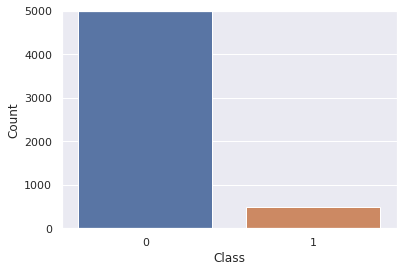

In [12]:
plt.figure(1)
sns.barplot(x='Class', y='N', data=res)
plt.xlabel('Class')
plt.ylabel('Count')
plt.ylim([0, 5000])

In [62]:
train = data.sampleBy('Class', fractions={0: 0.7, 1: 0.7}, seed=0)
test = data.subtract(train)

In [61]:
train.groupBy('Class').agg(F.count(train['Class']).alias('Counts')).show()
test.groupBy('Class').agg(F.count(test['Class']).alias('Counts')).show()

+-----+------+
|Class|Counts|
+-----+------+
|    1|   339|
|    0|199234|
+-----+------+

+-----+------+
|Class|Counts|
+-----+------+
|    1|   142|
|    0| 81278|
+-----+------+



In [63]:
features = [column for column in data.columns if column != 'Class']
assembler = VectorAssembler(inputCols=features, outputCol='features')
train = assembler.transform(dataset=train)
test = assembler.transform(dataset=test)

In [64]:
log_reg = LogisticRegression(featuresCol='features', labelCol='Class')
model = log_reg.fit(train)

In [65]:
evaluation = model.evaluate(test)

0.9772194648240831


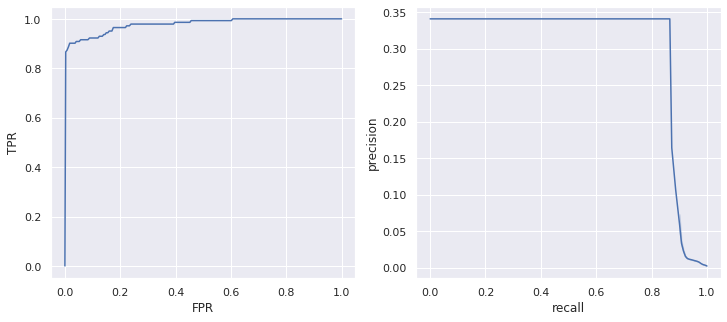

In [146]:
roc = evaluation.roc.toPandas()
pr = evaluation.pr.toPandas()
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.lineplot(x='FPR', y='TPR', data=roc, ax=ax[0])
sns.lineplot(x='recall', y='precision', data=pr, ax=ax[1])


In [124]:
evals = evaluation.predictions
tp = evals.groupBy().agg(F.sum(F.when((evals['Class'] == 1) & (evals['prediction'] == 1), 1))).collect()
fp = evals.groupBy().agg(F.sum(F.when((evals['Class'] == 0) & (evals['prediction'] == 1), 1))).collect()
tn = evals.groupBy().agg(F.sum(F.when((evals['Class'] == 0) & (evals['prediction'] == 0), 1))).collect()
fn = evals.groupBy().agg(F.sum(F.when((evals['Class'] == 1) & (evals['prediction'] == 0), 1))).collect()

In [129]:
print(tp[0][0], fp[0][0])
print(fn[0][0], tn[0][0])

92 17
50 81261


0.9991771063620731